In [25]:
import os 
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime

## Importin S&P500 Data

In [27]:
df = pd.read_csv('SP500.csv')

In [28]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Jun 07, 2021","4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,"Jun 04, 2021","4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,"Jun 03, 2021","4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,"Jun 02, 2021","4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,"Jun 01, 2021","4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"


In [30]:
df.describe()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,Date,Open,High,Low,Close*,Adj Close**,Volume
count,1258,1258,1258,1258,1258,1258,1258
unique,1258,1248,1252,1251,1252,1252,1257
top,"Mar 21, 2017","2,832.41","2,271.78","2,160.39","2,268.90","2,268.90","3,884,480,000"
freq,1,2,2,2,2,2,2


In [35]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         1258 non-null   object
 1   Open         1258 non-null   object
 2   High         1258 non-null   object
 3   Low          1258 non-null   object
 4   Close*       1258 non-null   object
 5   Adj Close**  1258 non-null   object
 6   Volume       1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [38]:
df.isnull().sum()


# no null values present

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

## Data Preparation

Converting date column to date values.

In [ ]:
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2021-06-07,"4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,2021-06-04,"4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,2021-06-03,"4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,2021-06-02,"4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,2021-06-01,"4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"
...,...,...,...,...,...,...,...
1253,2016-06-14,"2,076.65","2,081.30","2,064.10","2,075.32","2,075.32","3,759,770,000"
1254,2016-06-13,"2,091.75","2,098.12","2,078.46","2,079.06","2,079.06","3,392,030,000"
1255,2016-06-10,"2,109.57","2,109.57","2,089.96","2,096.07","2,096.07","3,515,010,000"
1256,2016-06-09,"2,115.65","2,117.64","2,107.73","2,115.48","2,115.48","3,290,320,000"


Converting the other columns to float

In [71]:
    df.iloc[:]

0       3,835,570,000
1       3,487,070,000
2       4,579,450,000
3       4,860,930,000
4       4,122,960,000
            ...      
1253    3,759,770,000
1254    3,392,030,000
1255    3,515,010,000
1256    3,290,320,000
1257    3,562,060,000
Name: Volume, Length: 1258, dtype: object

In [66]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
'en_US.UTF-8'

'en_US.UTF-8'

In [81]:
for i in range(1,7):
    df.iloc[:,i]=df.iloc[:,i].apply(lambda x: float(x.replace(',','')))

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1258 non-null   datetime64[ns]
 1   Open         1258 non-null   float64       
 2   High         1258 non-null   float64       
 3   Low          1258 non-null   float64       
 4   Close*       1258 non-null   float64       
 5   Adj Close**  1258 non-null   float64       
 6   Volume       1258 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.9 KB


In [102]:
sns.set(rc={'figure.figsize':(14,6)})

Date
Open


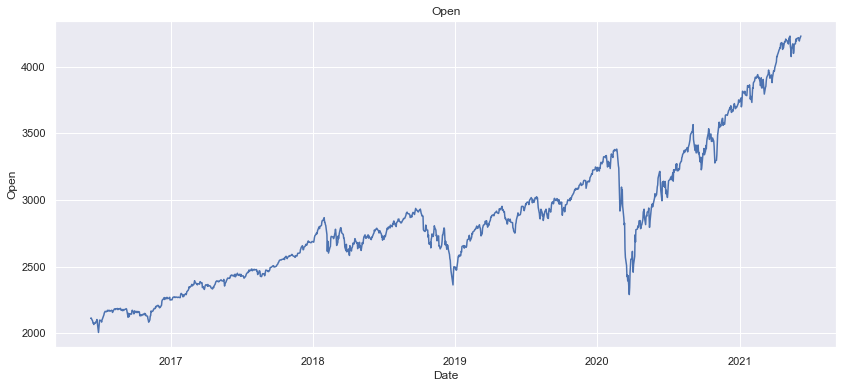

High


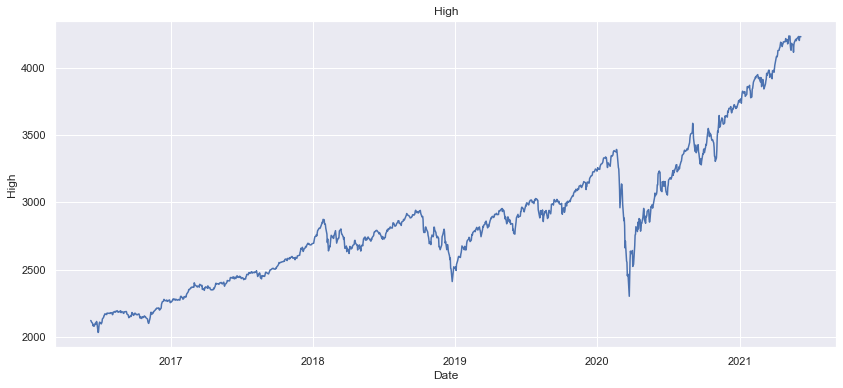

Low


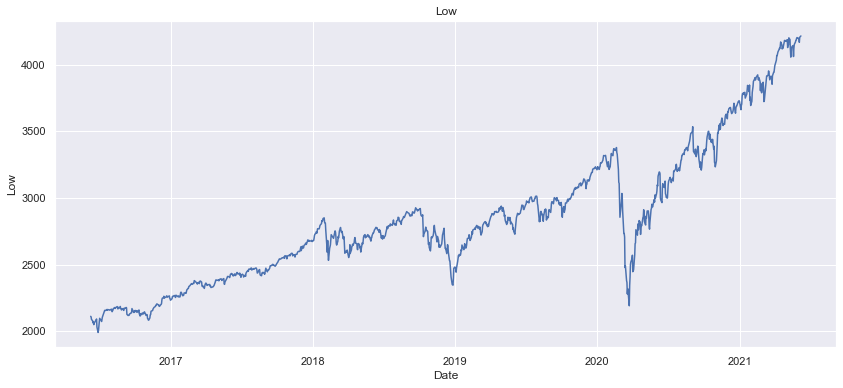

Close*


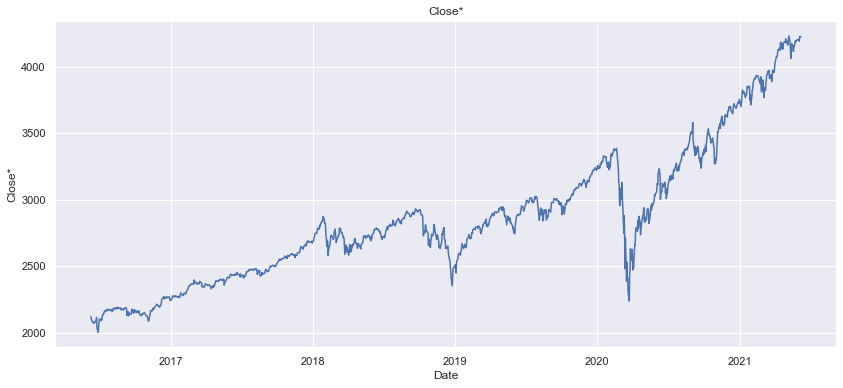

Adj Close**


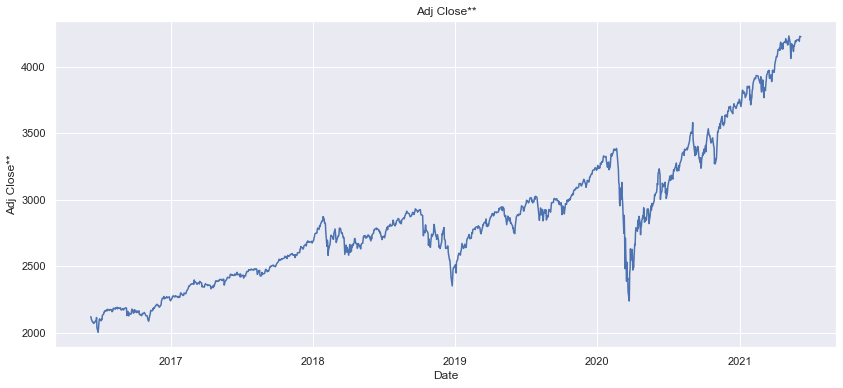

Volume


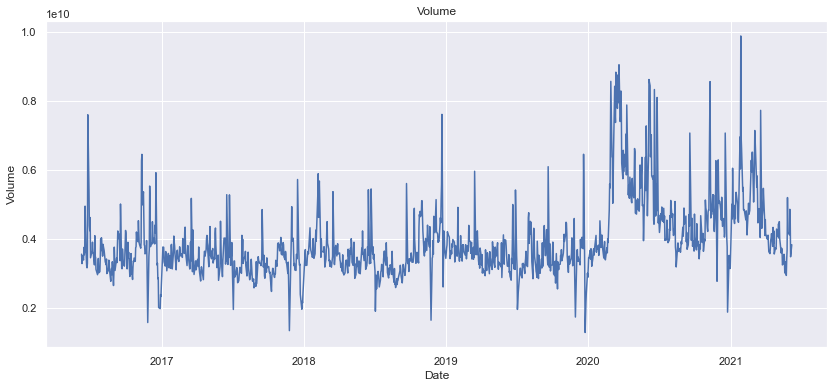

In [111]:
sns.set_theme(style="darkgrid")
for column in list(df.columns):
    print(column)
    if column != "Date":
        sns.lineplot(x="Date", y=column, data=df).set_title(column)
        plt.show()
        